In [1]:
# import generator from '../data/generator.py'
import sys
import os
from generator import *

2024-03-13 11:19:47.297467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Graph Generation

In [2]:
n = [10, 20]
p = 0.3

dataset = RandomGraphDataset(root='./data', gen_num_graph=500, n=n, p=p)

Generating 500 graphs


100%|██████████| 500/500 [00:00<00:00, 871.56it/s]
Processing...
100%|██████████| 500/500 [00:02<00:00, 212.45it/s]
Done!


In [4]:
dataset[0].s.size()

torch.Size([17])

In [ ]:
import torch
from torch import nn
from encoder import Encoder
from decoder import Decoder
from mpnn import MPNN

class Network(nn.Module):
    def __init__(self, latent_dim=128):
        super(Network, self).__init__()
        self.encoder = Encoder(2, latent_dim)
        self.processor = MPNN(latent_dim*2, latent_dim)
        self.decoder = Decoder(latent_dim, 1)

    def forward(self, x, edge_index):
        z = self.encoder(x)
        h = torch.zeros(x.size(0), 128)
        processor_input = torch.cat([z, h], dim=1)
        x = self.processor(processor_input, edge_index)
        x = self.decoder(x)
        return x

In [ ]:
from torch.functional import F
from torch import nn
import torch

class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()

    def forward(self, batch:torch.tensor, batch_pred: torch.Tensor):
        # for every batch find the predicted and true values and send them to the calculate_loss function
        loss_x = 0
        loss_h = 0
        for i in range(batch.size(0)):
            data = batch[i]
            x = data.reach_h[-1] # true output value
            x_pred = batch_pred[i][-1] # predicted output value
            h_pred = batch_pred[i][:-2] # predicted hint values
            h = data.reach_h[:len(h_pred)] # true hint values
            loss_x += F.binary_cross_entropy(x, x_pred)
            print(loss_x)
            for i in range(h.size(1)):
                loss_h += F.binary_cross_entropy(h[:, i], h_pred[:, i])

        return loss_x, loss_h

In [2]:
import torch
from torch import nn
from encoder import Encoder
from decoder import Decoder
from mpnn import MPNN
from torch.functional import F

class Network(nn.Module):
    def __init__(self, latent_dim=128):
        super(Network, self).__init__()
        self.encoder = Encoder(2, latent_dim)
        self.processor = MPNN(latent_dim*2, latent_dim)
        self.decoder = Decoder(latent_dim, 1)

    def forward(self, batch, max_iter=10):
        input = torch.stack((batch.pos, batch.s), dim=1).float()
        h = torch.zeros(input.size(0), 128) # hidden state from the processor
        hints = batch.reach_h[1:] # hints from the reachability
        true_output = batch.reach_h[-1] # true_output expected from the reachability
        max_iter = hints.size(0)+1
        predictions = torch.zeros(max_iter, input.size(0))

        for i in range(max_iter):
            z = self.encoder(input) # the encoded input
            processor_input = torch.cat([z, h], dim=1) # the input to the processor
            h = self.processor(processor_input, batch.edge_index.long()) # the output of the processor
            y = self.decoder(z, h).view(batch.s.size())   # decoded state from the processor
            predictions[i] = y
            input = torch.stack((batch.pos, y), dim=1).float() # we update the input with the new state
        
        loss = self.calculate_loss(hints, predictions, true_output)
        return y, loss
    
    def calculate_loss(self, hints, predictions, true_output):
        loss_x = F.binary_cross_entropy(torch.sigmoid(predictions[-1]), true_output.type(torch.float))
        loss_h = 0
        for i in range(hints.size(0)):
            loss_h += F.binary_cross_entropy(torch.sigmoid(predictions[i]), hints[i].type(torch.float))
        return loss_x, loss_h

In [5]:
import torch
from torch import nn
from encoder import Encoder
from decoder import Decoder
from mpnn import MPNN
from torch.functional import F

class Network(nn.Module):
    def __init__(self, latent_dim=128):
        super(Network, self).__init__()
        self.encoder = Encoder(2, latent_dim)
        self.processor = MPNN(latent_dim*2, latent_dim)
        self.decoder = Decoder(latent_dim, 1)

    def forward(self, batch, max_iter=10):
        input = torch.stack((batch.pos, batch.s), dim=1).float()
        h = torch.zeros(input.size(0), 128) # hidden state from the processor
        hints = batch.reach_h[1:] # hints from the reachability
        true_output = batch.reach_h[-1] # true_output expected from the reachability
        max_iter = hints.size(0)+1
        predictions = torch.zeros(max_iter, input.size(0))

        for i in range(max_iter):
            z = self.encoder(input) # the encoded input
            processor_input = torch.cat([z, h], dim=1) # the input to the processor
            h = self.processor(processor_input, batch.edge_index.long()) # the output of the processor
            y = self.decoder(z, h).view(batch.s.size())   # decoded state from the processor
            predictions[i] = y
            input = torch.stack((batch.pos, y), dim=1).float() # we update the input with the new state
        
        loss = self.calculate_loss(hints, predictions, true_output)
        return y, loss
    
    def calculate_loss(self, hints, predictions, true_output):
        loss_x = F.binary_cross_entropy_with_logits(predictions[-1], true_output.type(torch.float))
        loss_h = 0
        for i in range(hints.size(0)):
            loss_h += F.binary_cross_entropy_with_logits(predictions[i], hints[i].type(torch.float))
        return loss_x, loss_h

In [6]:
def train(model, train_dataset, validation_dataset=None, optimizer=None, epochs=10, batch_size=5):
    x_loss_weight = 0.5
    h_loss_weight = 1 - x_loss_weight
    # for plotting save the losses
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        batch_count = len(train_dataset) // batch_size
        for i in range(batch_count):
            model.train()
            cumulated_loss = 0
            for j in range(i*batch_size, (i+1)*batch_size):
                graph = train_dataset[j] 
                y, loss = model(graph)
                loss_x = loss[0] # loss for the output
                loss_hints = loss[1] # loss for the hints
                cumulated_loss += x_loss_weight * loss_x + h_loss_weight * loss_hints # we combine the two losses
            
            cumulated_loss /= batch_size
            optimizer.zero_grad()
            cumulated_loss.backward()
            optimizer.step()


        if validation_dataset:
            model.eval()
            cumulated_loss_val = 0
            with torch.no_grad():
                for k in range(len(validation_dataset)):
                    graph = validation_dataset[k]
                    y, loss = model(graph)
                    loss_x, loss_hints = loss[0], loss[1]
                    cumulated_loss_val += x_loss_weight * loss_x + h_loss_weight * loss_hints

            cumulated_loss_val /= len(validation_dataset)

            print(f'Epoch {epoch}, loss {cumulated_loss.item()}, validation loss {cumulated_loss_val}')
            val_losses.append(cumulated_loss_val.item())

        else:
            print(f'Epoch {epoch}, loss {cumulated_loss.item()}')
        train_losses.append(cumulated_loss.item()) 
        
        if len(val_losses) > 5:
                    if val_losses[-1] > val_losses[-2] > val_losses[-3] > val_losses[-4] > val_losses[-5]:
                        print('Early stopping')
                        break
    return train_losses, val_losses


In [16]:
# split the dataset into training and testing using the train_test_split function
from torch.utils.data import random_split
n=[20, 100]
p=0.3
dataset = RandomGraphDataset(root='./data', gen_num_graph=500, n=n, p=p)
train_dataset, test_dataset = random_split(dataset, [400, 100])

Generating 500 graphs


100%|██████████| 500/500 [00:03<00:00, 144.00it/s]
Processing...
100%|██████████| 500/500 [00:14<00:00, 34.84it/s]
Done!


In [20]:
# create a test set
n=[100, 1000]
p=0.3

test_dataset = RandomGraphDataset(root='./data/test', gen_num_graph=100, n=n, p=p)

Generating 100 graphs


100%|██████████| 100/100 [00:24<00:00,  4.15it/s]
Processing...
 14%|█▍        | 14/100 [04:00<24:37, 17.18s/it]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/5z/9sf4md8x7mz2fb2__552jv940000gn/T/ipykernel_11430/3308943236.py", line 5, in <module>
    test_dataset = RandomGraphDataset(root='./data/test', gen_num_graph=100, n=n, p=p)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hattaliahmed/Documents/3. Github/NAR/models/generator.py", line 92, in __init__
    super(RandomGraphDataset, self).__init__(root, transform, pre_transform)
  File "/usr/local/anaconda3/lib/python3.11/site-packages/torch_geometric/data/dataset.py", line 118, in __init__
    self._process()
  File "/usr/local/anaconda3/lib/python3.11/site-packages/torch_geometric/data/dataset.py", line 263, in _process
    self.process()
  File "/Users/hattaliahmed/Documents/3. Github/NAR/models/generator.py",

In [17]:
optimizer = torch.optim.Adam
model = Network()
lr = 0.001

train_loss, val_losses = train(model=model, train_dataset=train_dataset, validation_dataset=test_dataset,
      optimizer=optimizer(model.parameters(), lr=lr), epochs=15, batch_size=32)

Epoch 0, loss 0.474441260099411, validation loss 0.483560174703598
Epoch 1, loss 0.2088150680065155, validation loss 0.18745948374271393
Epoch 2, loss 0.008495943620800972, validation loss 0.006550794932991266
Epoch 3, loss 0.00042512972140684724, validation loss 0.00037600912037305534
Epoch 4, loss 9.510121890343726e-05, validation loss 9.221333311870694e-05
Epoch 5, loss 4.748110950458795e-05, validation loss 4.7312365495599806e-05
Epoch 6, loss 3.1041312468005344e-05, validation loss 3.187461697962135e-05
Epoch 7, loss 2.4472823497490026e-05, validation loss 2.5687741072033532e-05
Epoch 8, loss 2.107813816110138e-05, validation loss 2.2359427021001466e-05
Epoch 9, loss 1.8665112293092534e-05, validation loss 1.9870582036674023e-05
Epoch 10, loss 1.6638863598927855e-05, validation loss 1.77220645127818e-05
Epoch 11, loss 1.4860472219879739e-05, validation loss 1.5818113752175122e-05
Epoch 12, loss 1.3286005014379043e-05, validation loss 1.4136039681034163e-05
Epoch 13, loss 1.1898310

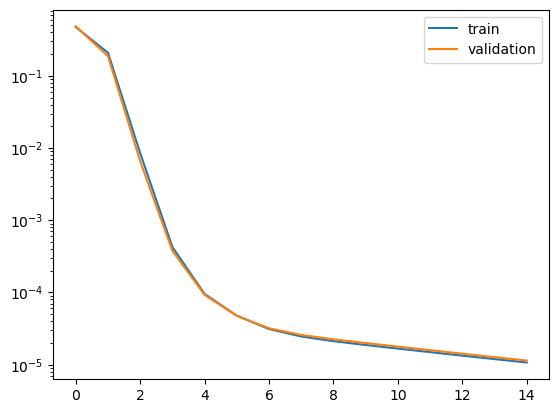

In [19]:
# plot the losses
import matplotlib.pyplot as plt
plt.plot(train_loss, label='train')
plt.plot(val_losses, label='validation')
plt.legend()
# use log scale
plt.yscale('log')
plt.show()

In [ ]:
i =31
graph = test_dataset[i]
print(graph.reach_h[-1])
print(torch.sigmoid(model(graph)[0]))

tensor([1., 0., 1., 1., 1., 0.], dtype=torch.float64)
tensor([1.0000, 0.0507, 1.0000, 1.0000, 1.0000, 0.0255],
       grad_fn=<SigmoidBackward0>)


In [ ]:
model(graph)[0]

tensor([3500525.5000, 3524301.5000, 3249399.0000, 3501471.5000, 3512054.0000,
        3518177.7500], grad_fn=<ViewBackward0>)

In [28]:
dataset[0].pi_h.size()

torch.Size([3, 2398])

In [ ]:
Network().forward(input, dataset[0].edge_index)

tensor([[-0.0748],
        [-0.0829],
        [-0.0641],
        [-0.0551],
        [-0.0525],
        [-0.0458]], grad_fn=<AddmmBackward0>)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lin = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(-1)
        return self.lin(x)

In [ ]:
encoder = Encoder(2)
z = encoder(input)

In [ ]:
h = torch.zeros(input.size(0), 128)

In [ ]:
z_ = torch.cat([z, h], dim=1)
z_.size()

torch.Size([6, 256])

In [ ]:
import torch
from torch_geometric.nn import MessagePassing
from torch.nn import Linear

class MPNN(MessagePassing):
  def __init__(self, in_channels, hidden_channels, activation=None):
    super(MPNN, self).__init__(aggr='max') #  "Max" aggregation.
    self.in_channels = in_channels
    self.hidden_channels = hidden_channels
    self.messages = Linear(self.in_channels * 2, self.hidden_channels)
    self.update_fn = Linear(self.in_channels + self.hidden_channels, self.hidden_channels)
    self.activation = activation

    self.mlp = torch.nn.Sequential(
        Linear(hidden_channels, hidden_channels),
        torch.nn.ReLU(),
        Linear(hidden_channels, self.hidden_channels)
    )
    
  def forward(self, x, edge_index):
    out = self.propagate(edge_index, x=x)
    out = self.mlp(out)
    if self.activation is not None:
      out = self.activation(out)
    return out
    
  def message(self, x_i, x_j):
    # x_i has shape [E, in_channels]
    # x_j has shape [E, in_channels]
    #print('MPNN => xi, xj', x_i.size(), x_j.size())
    tmp = torch.cat([x_i, x_j], dim=1)  # tmp has shape [E, 2 * in_channels]
    #print('MPNN => messages IN', tmp.size())
    m = self.messages(tmp)
    #print('MPNN => messages OUT', m.size())
    return m
  
  def update(self, aggr_out, x):
    # aggr_out has shape [N, out_channels]
    # x has shape [N, in_channels]
    #print(f'MPNN => x_i', x.size(), ' aggr_out ', aggr_out.size())
    tmp = torch.cat([x, aggr_out], dim=1)
    #print(f'MPNN => tmp', tmp.size())
    return self.update_fn(tmp)

In [ ]:
processor = MPNN(256, 128)

In [ ]:
hi = processor(z_, dataset[0].edge_index)

In [ ]:
hi.size()

torch.Size([6, 128])